# Python 使って CoVid-19 拡大状況を可視化してみよう
このノートブックでは，CoVid-19 の拡大状況に関するデータを使って，Pythonを使った可視化・グラフ作成手法を解説する．

まず，必要となるモジュールをインポートする．

In [0]:
import matplotlib.pyplot as plt # グラフ描画
import matplotlib.dates as mdates # グラフ上の日付の取り扱い
import pandas as pd # データの取り扱い
from datetime import datetime, timedelta # 時刻

次に，各国の感染者（PCR検査陽性数），感染死亡者および感染後回復者のデータをグラフにしてみよう．
データの読み込み・整形は少しテクニカルなので，慣れないうちは「ふーん，そうやるんだ」くらいに思っておけばいい．

In [0]:
#
# ファイルをデータフレームに読み込む
#
prefix="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_"
suffix="_global.csv"
# 累積感染者数，累積死亡者，累積回復者のデータをデータフレームに読み込む
confirmed_df = pd.read_csv(prefix+"confirmed"+suffix)
deaths_df = pd.read_csv(prefix+"deaths"+suffix)
recovered_df = pd.read_csv(prefix+"recovered"+suffix)
# 県・州および緯度・軽度データを取り除き，列名を取り扱いやすい日付形式に整形する関数
def reformat(df):
    # 県・州べつのデータを削除し，行インデックスを Country/Region にする
    drop_rows = [l for l in range(len(df)) if not pd.isnull(df.loc[l,'Province/State'])]
    df = df.drop(drop_rows).set_index("Country/Region")
    # 緯度・軽度データを取り除く
    df = df.iloc[:,3:]
    # 列インデックスを標準的な datetime 型に置き換える
    df.columns = pd.to_datetime(df.columns, format='%m/%d/%y')
    return df
# 関数 reformat を使って全てのデータフレームを整形
confirmed_df = reformat(confirmed_df)
deaths_df = reformat(deaths_df)
recovered_df = reformat(recovered_df)

この整形によって，各国の感染状況が以下の3つのデータフレームに格納される
1. `confirmed_df`: 感染者数
2. `deaths_df`: 死亡者数
3. `recovered_df`: 回復者数

それぞれのデータフレームは，Excel の表みたいな感じになっている．この場合は，各行が国に対応し，各列が日付に対応している．
次のセルを実行すれば，どんな感じの形式になっているかイメージが掴めるだろう：

In [3]:
confirmed_df

,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,2020-02-20,2020-02-21,2020-02-22,2020-02-23,2020-02-24,2020-02-25,2020-02-26,2020-02-27,2020-02-28,2020-02-29,2020-03-01,...,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30,2020-03-31,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05,2020-04-06,2020-04-07,2020-04-08,2020-04-09,2020-04-10,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,...,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120,170,174,237,273,281,299,349,367,423,444,484,521,555,607,665,714,784,840,906
Albania,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146,174,186,197,212,223,243,259,277,304,333,361,377,383,400,409,416,433,446,467,475,494,518,539
Algeria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,...,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511,584,716,847,986,1171,1251,1320,1423,1468,1572,1666,1761,1825,1914,1983,2070,2160,2268,2418
Andorra,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188,224,267,308,334,370,376,390,428,439,466,501,525,545,564,583,601,601,638,646,659,673,673,696
Angola,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3,3,4,4,5,7,7,7,8,8,8,10,14,16,17,19,19,19,19,19,19,19,19,19,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Malawi,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,4,4,5,8,8,8,9,12,13,16,16,16,16,17
South Sudan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,2,3,4,4,4,4,4,4,4,4
Western Sahara,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,4,4,4,4,6,6,6,6,6,6


データフレーム`df`から特定の行もしくは特定の列を取り出すには，以下のコマンドを使う：
- `df.loc['Japan']` : `Japan` なる行を取り出す
- `df['2020-01-22']` : `2020-01-22` なる列を取り出す
- `df.iloc[n]` : n行目を取り出す（nは0からデータフレームの行数-1の値）
- `df.iloc[:,m]` : m列目を取り出す（mは0からデータフレームの列数-1の値）

In [4]:
# 日本の時系列データを得る
print(deaths_df.loc['Japan'])
# 3/31日時点の各国の累積死者数を得る
print(deaths_df['2020-03-31'])
# 行番号1の時系列データを得る（行番号は0から始まることに注意）
print(deaths_df.iloc[1])
# 列番号2の日の各国のデータを得る（列番号は0から始まることに注意）
print(deaths_df.iloc[:,2])

2020-01-22      0
2020-01-23      0
2020-01-24      0
2020-01-25      0
2020-01-26      0
             ... 
2020-04-13    123
2020-04-14    143
2020-04-15    146
2020-04-16    178
2020-04-17    190
Name: Japan, Length: 87, dtype: int64
Country/Region
Afghanistan               4
Albania                  15
Algeria                  44
Andorra                  12
Angola                    2
                         ..
Malawi                    0
South Sudan               0
Western Sahara            0
Sao Tome and Principe     0
Yemen                     0
Name: 2020-03-31 00:00:00, Length: 182, dtype: int64
2020-01-22     0
2020-01-23     0
2020-01-24     0
2020-01-25     0
2020-01-26     0
              ..
2020-04-13    23
2020-04-14    24
2020-04-15    25
2020-04-16    26
2020-04-17    26
Name: Albania, Length: 87, dtype: int64
Country/Region
Afghanistan              0
Albania                  0
Algeria                  0
Andorra                  0
Angola                   0
           

このデータを使って，Fiancial Times が載せているような以下の図を作成してみよう：

![](https://www.ft.com/__origami/service/image/v2/images/raw/http%3A%2F%2Fcom.ft.imagepublish.upp-prod-us.s3.amazonaws.com%2F82051618-80dd-11ea-82f6-150830b3b99a?fit=scale-down&quality=highest&source=next&width=600)

まずは，細かいことを考えず，データフレーム`deaths_df`の全ての国（全ての行）について，全ての日付（全ての列）で観測された死亡者数をプロットしみよう．国によって死者数が10人だったり１万以上だったりするので，y軸方向は対数を撮って表示することにする．

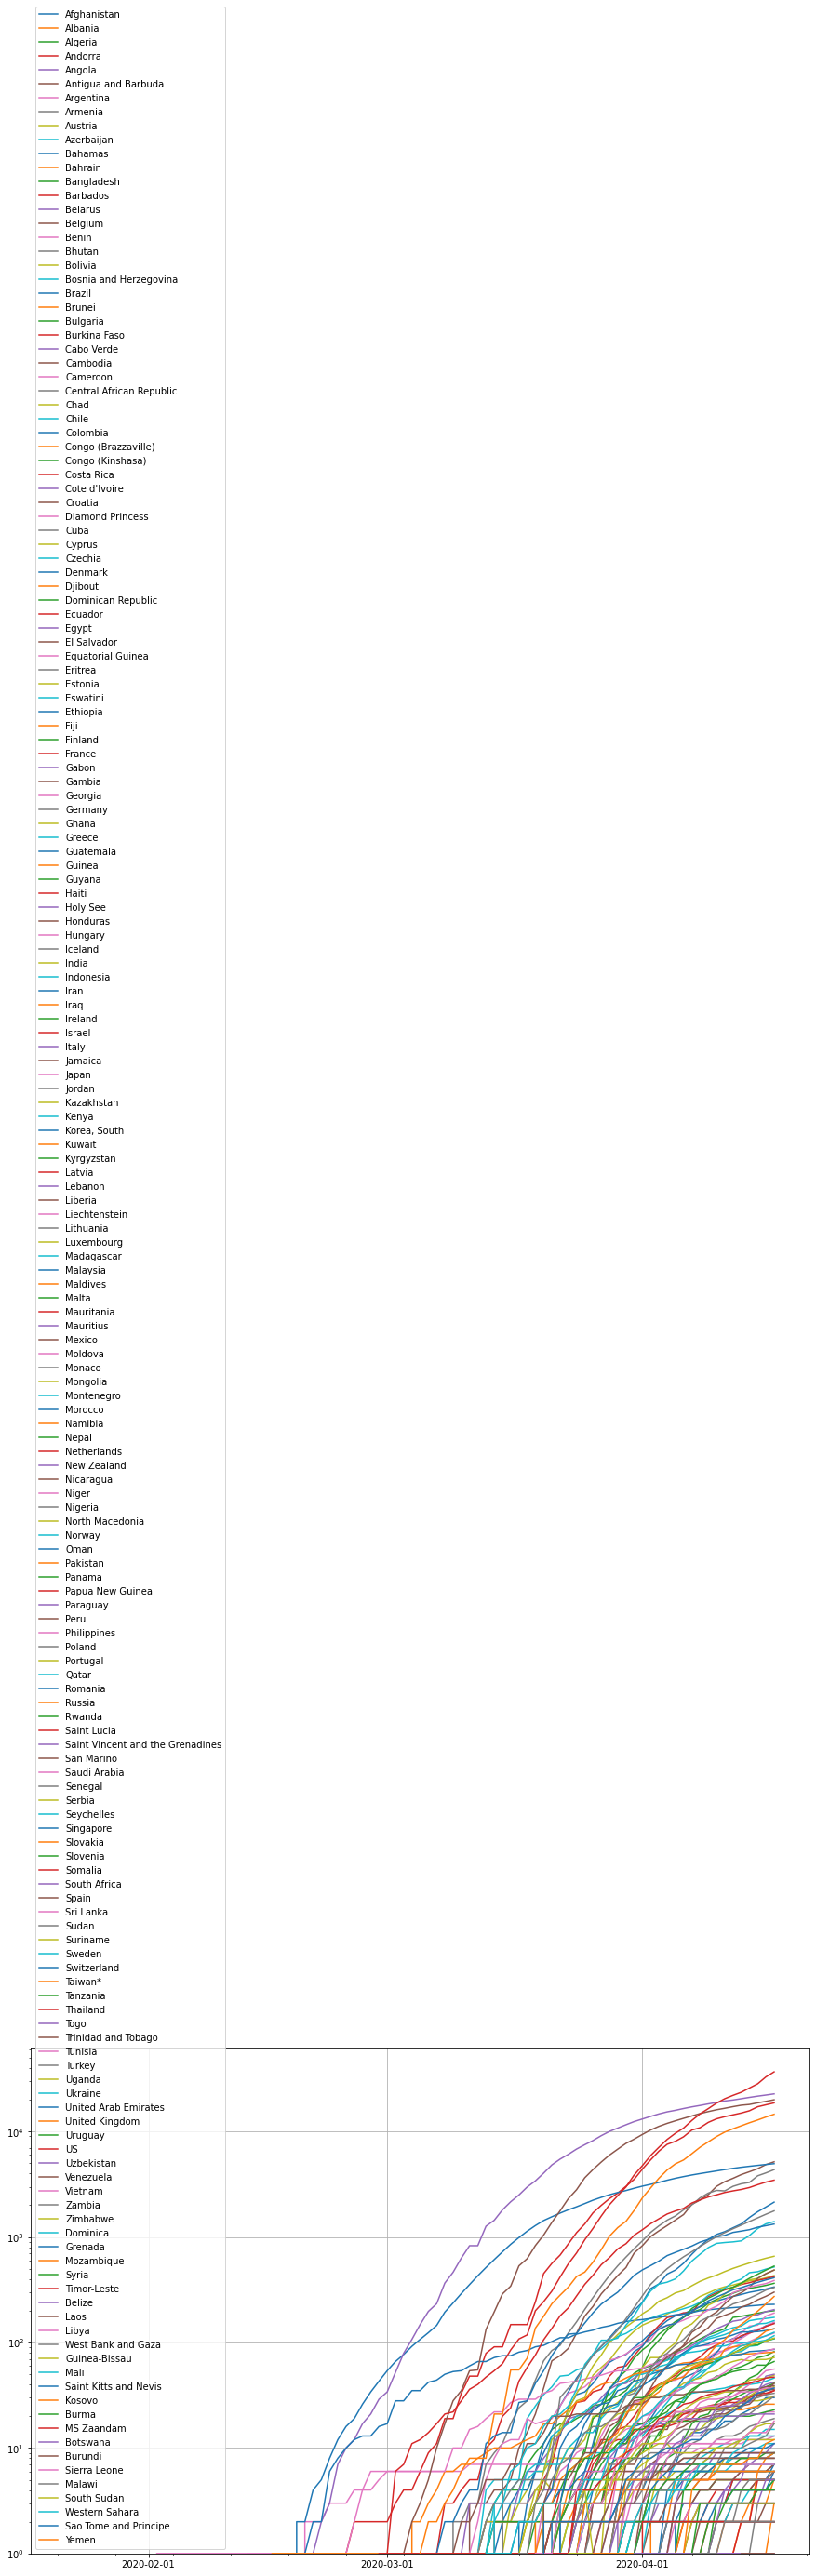

In [5]:
#
# いくつかの国について，死亡者数を対数で表示
#
# 国名リスト
country_set = deaths_df.index
#country_set = ['US', 'France', 'Italy', 'Germany', 'Japan']

# 与えられたデータフレームと国名リストについて累積数グラフをプロットする関数
def plot_cum(df, country_set):
    # 図の準備
    fig, ax = plt.subplots(figsize=(15,10))
    # 国名リストのそれぞれについて，死亡者数をプロット
    for country in country_set:
        plt.plot(df.loc[country], label=country)
        # death_df.loc[country] は，death_df というデータフレームの中で country に相当する行を取り出す命令
    # 見やすくなるように，x軸の大目盛を月ごと，小目盛を週ごとにする
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_locator(mdates.WeekdayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    # フォントが小さいので大きくする
    xticklabels = ax.get_xticklabels()
    yticklabels = ax.get_yticklabels()
    # y軸スケールを対数に（線形にする時は yscale('linear')
    plt.yscale('log')
    # 格子を表示
    plt.grid()
    # 凡例を表示
    plt.legend()
    plt.ylim([1,plt.ylim()[1]])
    plt.show()
    return fig, ax
fig, ax = plot_cum(deaths_df, country_set)

おめでとう，過去10年間の台風の軌跡の完成です．

# つーか、ぎゃぁ。

そりゃそうだ．下記のセルを実行すれば分かる：

In [6]:
len(deaths_df)

182

ように，このデータフレームには180カ国以上のデータが入っている（データ形式の事情から，中国，オーストラリア，カナダは抜けている）．それを一度にプロットしたから**情報過多**になっている．

そこで，累積死亡者が多い順に上位10位の国と日本だけをプロットするように修正してみよう．

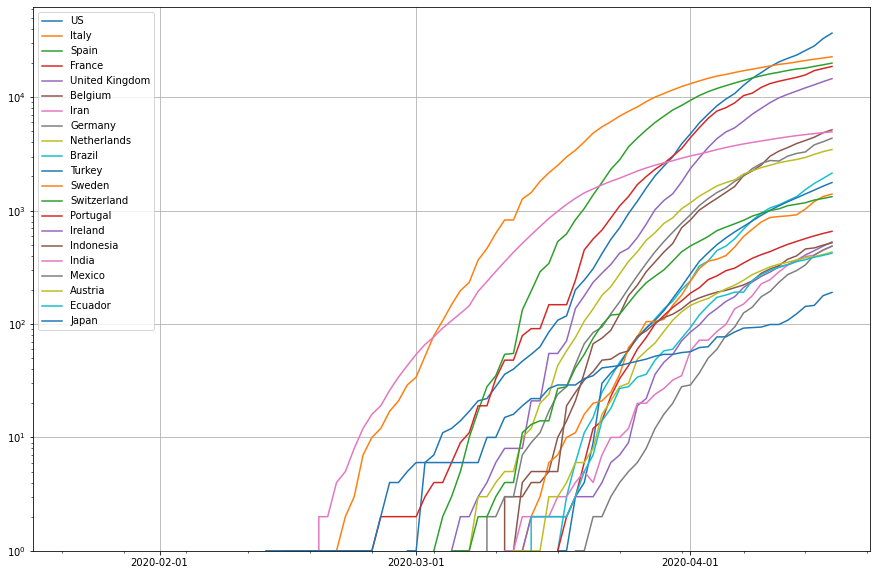

In [7]:
#
# いくつかの国について，死亡者数を対数で表示
#
# 国名リスト
th_rank = 20 # 上位何位までを表示するか
#country_set = ['US', 'United Kingdom', 'Spain', 'France', 'Italy', 'Germany', 'Austria', 'Norway', 'Korea, South', 'Iran', 'India', 'Indonesia', 'Japan']
# 次の1行はちょっとテクニカル．最新の死亡者数（符号反転）と国名のタプルを sorted で並べ，
# 最初から th_rank 個を取り出した後，zip(*)で再び死亡者数(num)と国名(country_set)に分解
num, country_set = zip(*sorted([(-deaths_df.loc[country][-1], country) for country in deaths_df.index])[:th_rank])
# country_set を list 形式に直す
country_set = list(country_set)
# もし日本が country_set に含まれていないなら追加する
if 'Japan' not in country_set:
    country_set += ['Japan']
# plot_cum_deaths を呼び出す
fig, ax = plot_cum(deaths_df, country_set)

このグラフでプロットしているのは**累積**死亡者なので，これを**1日あたり**の死亡者数にしてみよう．
関数`plot_cum`で`plt.plot`を呼び出している部分を下記のように修正すればいい：

元データの累積値をそのままプロットする場合：
```
plt.plot(df.loc[country], label=country)
```
差分をプロットする場合：
```
plt.plot(df.loc[country].diff(), label=country)
```

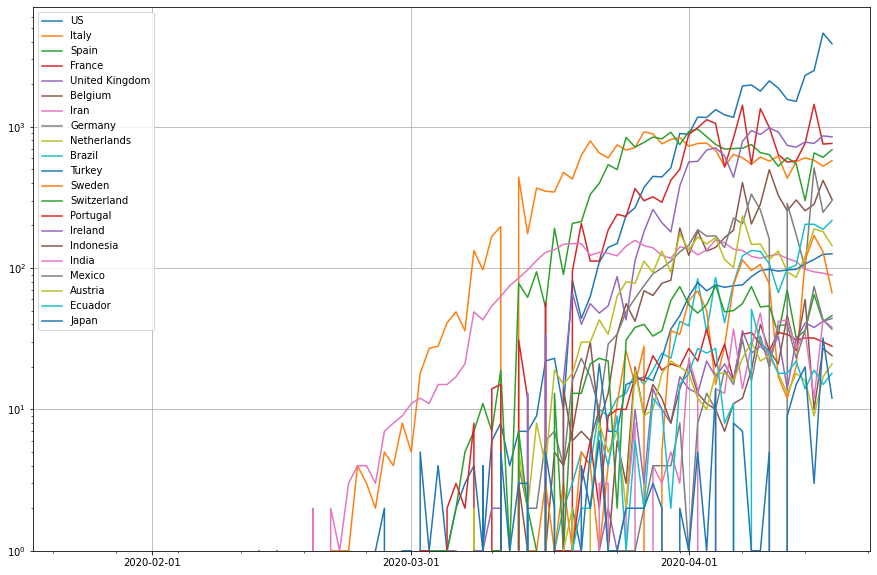

In [8]:
#
# 一日あたりの人数をプロット
#
def plot_daily(df, country_set):
    # 図の準備
    fig, ax = plt.subplots(figsize=(15,10))
    # 国名リストのそれぞれについて，データフレームの値をプロット
    for country in country_set:
        plt.plot(df.loc[country].diff(), label=country)
        # death_df.loc[country] は，death_df というデータフレームの中で country に相当する行を取り出す命令
    # 見やすくなるように，x軸の大目盛を月ごと，小目盛を週ごとにする
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_locator(mdates.WeekdayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    # y軸スケールを対数に（線形にする時は yscale('linear')
    plt.yscale('log')
    # 格子を表示
    plt.grid()
    # 凡例を表示
    plt.legend()
    plt.ylim([1,plt.ylim()[1]])
    plt.show()
    return fig, ax
# 呼び出す
fig, ax = plot_daily(deaths_df, country_set)

さらに，m日間移動平均になおしてみる．m日間分の「窓」を適用するには`rolling(m)`として，その平均を求めるには`mean()`関数を用いればよい．ここでは窓の長さを関数の引数`window`で指定する（省略した場合のデフォルトは7日とする）ことにする．このとき，`plt.plot`の行を以下のようにすれば，移動平均がプロットできる．
```
plt.plot(df.loc[country].diff().rolling(window).mean(), label=country)
```

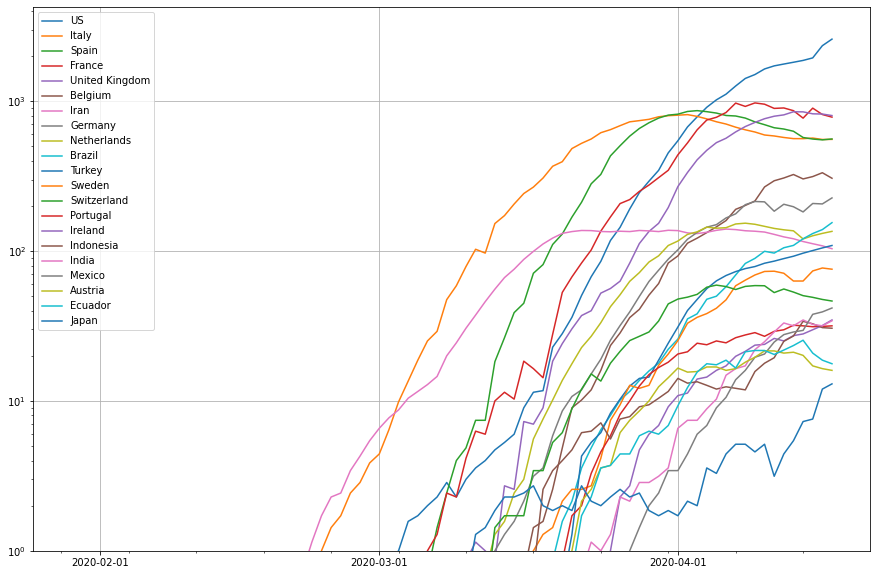

In [9]:
#
# 一日あたりの人数の移動平均値をプロット
#
def plot_daily_rolling(df, country_set, window=7):
    # 図の準備
    fig, ax = plt.subplots(figsize=(15,10))
    # 国名リストのそれぞれについて，データフレームの値をプロット
    for country in country_set:
        plt.plot(df.loc[country].diff().rolling(window).mean(), label=country)
        # death_df.loc[country] は，death_df というデータフレームの中で country に相当する行を取り出す命令
    # 見やすくなるように，x軸の大目盛を月ごと，小目盛を週ごとにする
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_locator(mdates.WeekdayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    # y軸スケールを対数に（線形にする時は yscale('linear')
    plt.yscale('log')
    # 格子を表示
    plt.grid()
    # 凡例を表示
    plt.legend()
    plt.ylim([1,plt.ylim()[1]])
    plt.show()
    return fig, ax
# 呼び出す
fig, ax = plot_daily_rolling(deaths_df, country_set)

さらに，Financial Times では「1日あたりの死亡者が3名を超えてからの日数」を横軸にとっている．

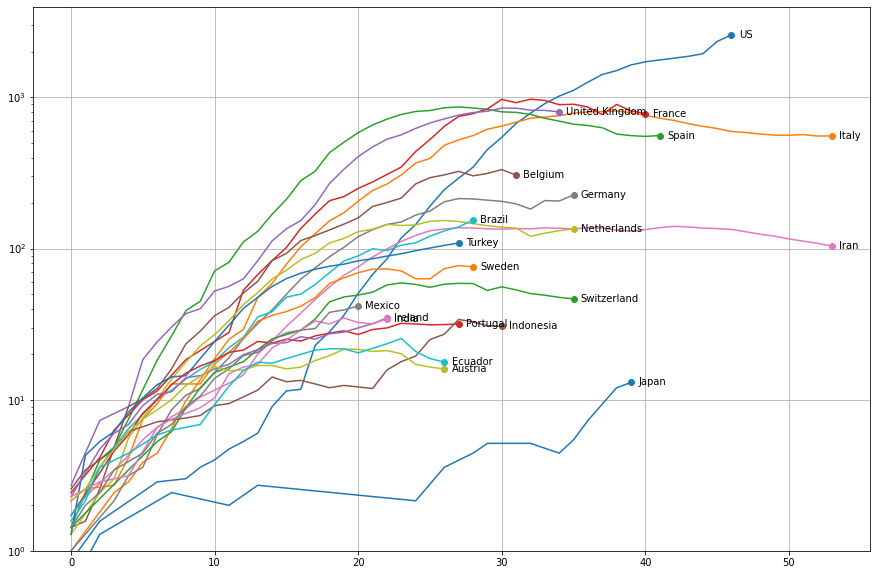

In [10]:
def plot_daily_rolling_by_days(df, country_set, window=7):
    # 図の準備
    fig, ax = plt.subplots(figsize=(15,10))
    # 国名リストのそれぞれについて，データフレームの値をプロット
    for country in country_set:
        daily = df.loc[country].diff() # 一日あたりの
        daily_index = daily[daily>3].index
        daily_rolling = daily.rolling(7).mean()[daily_index]
        days = (daily_index-daily_index[0]).days
        curve = ax.plot(days, daily_rolling, label=country)
        x, y = days[-1], daily_rolling[-1]
        ax.plot(x, y, 'o', color=curve[0].get_color())
        ax.text(x+0.5, y, country, verticalalignment='center')
    # y軸スケールを対数に（線形にする時は yscale('linear')
    plt.yscale('log')
    # 格子を表示
    plt.grid()
    plt.ylim([1,plt.ylim()[1]])
    plt.show()
    return fig, ax
# 呼び出す
fig, ax = plot_daily_rolling_by_days(deaths_df, country_set)

だいぶ近づいたかも．

![](https://www.ft.com/__origami/service/image/v2/images/raw/http%3A%2F%2Fcom.ft.imagepublish.upp-prod-us.s3.amazonaws.com%2F82051618-80dd-11ea-82f6-150830b3b99a?fit=scale-down&quality=highest&source=next&width=800)

でも，やはり最大の感染者を出している中国が入ってないと完成した感じがしない．

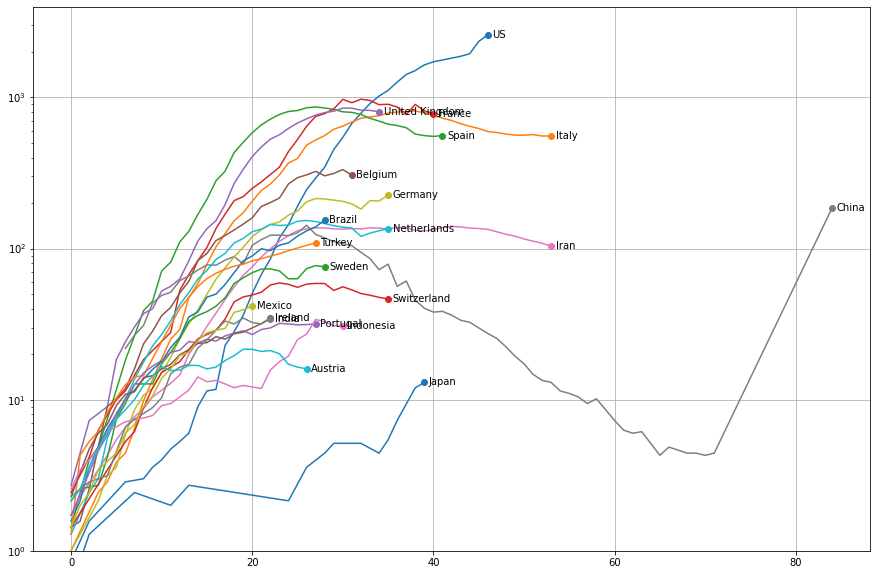

In [11]:
#
# ファイルをデータフレームに読み込む
#
prefix="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_"
suffix="_global.csv"
# Province/State別のデータのみが提供されている国
no_summary_country_set = ['China', 'Australia'] 
# 累積感染者数，累積死亡者，累積回復者のデータをデータフレームに読み込む
confirmed_df = pd.read_csv(prefix+"confirmed"+suffix)
deaths_df = pd.read_csv(prefix+"deaths"+suffix)
recovered_df = pd.read_csv(prefix+"recovered"+suffix)
# 県・州および緯度・軽度データを取り除き，列名を取り扱いやすい日付形式に整形する関数
def reformat(df):
    df = df.set_index("Country/Region")
    # 県・州別データしかない国について，その総和をとったものを記録しておく
    series = dict()
    for country in no_summary_country_set:
        series[country] = pd.Series(df.loc[country].iloc[:,3:].sum(), index = df.columns[3:], name=country)
    # いったん行インデックスを番号に戻す
    df = df.reset_index()
    # 県・州べつのデータを削除し，行インデックスを Country/Region にする
    drop_rows = [l for l in range(len(df)) if not pd.isnull(df.loc[l,'Province/State'])]
    df = df.drop(drop_rows).set_index("Country/Region")
    # 緯度・軽度データを取り除く
    df = df.iloc[:,3:]
    # 記録しておいた国のデータを追加
    for s in series:
        df = df.append(series[s])
    # 列インデックスを標準的な datetime 型に置き換える
    df.columns = pd.to_datetime(df.columns, format='%m/%d/%y')
    return df

# 関数 reformat を使って全てのデータフレームを整形
confirmed_df = reformat(confirmed_df)
deaths_df = reformat(deaths_df)
recovered_df = reformat(recovered_df)

# 国名リスト
th_rank = 20 # 上位何位までを表示するか
#country_set = ['US', 'United Kingdom', 'Spain', 'France', 'Italy', 'Germany', 'Austria', 'Norway', 'Korea, South', 'Iran', 'India', 'Indonesia', 'Japan']
# 次の1行はちょっとテクニカル．最新の死亡者数（符号反転）と国名のタプルを sorted で並べ，
# 最初から th_rank 個を取り出した後，zip(*)で再び死亡者数(num)と国名(country_set)に分解
num, country_set = zip(*sorted([(-deaths_df.loc[country][-1], country) for country in deaths_df.index])[:th_rank])
# country_set を list 形式に直す
country_set = list(country_set)
# もし日本が country_set に含まれていないなら追加する
if 'Japan' not in country_set:
    country_set += ['Japan']
    
fig, ax = plot_daily_rolling_by_days(deaths_df, country_set)

かなりFinancial Times のグラフと近づいたが，上のグラフだと，中国が70日前後で突然死者数が増加している．

![](https://www.ft.com/__origami/service/image/v2/images/raw/http%3A%2F%2Fcom.ft.imagepublish.upp-prod-us.s3.amazonaws.com%2F82051618-80dd-11ea-82f6-150830b3b99a?fit=scale-down&quality=highest&source=next&width=800)

その原因として，CSSEが提供している[死者数データ](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv)で，Hubei, Chinaの累積死者数が以下のように急増しちえる

|Date| 4/16 | 4/17 |
| --- | ---- | ---- |
|Hubei, China| 3222 | 4512 |

In [12]:
confirmed_df = pd.read_csv(prefix+"confirmed"+suffix)
df = confirmed_df
# confirmed_df = confirmed_df.iloc[:]
series = dict()
no_summary_country_set = ['China', 'Australia', 'Canada']
df = df.set_index("Country/Region")
for country in no_summary_country_set:
    series[country] = pd.Series(df.loc[country].iloc[:,3:].sum(), index = df.columns[3:], name=country)
#s = pd.Series(, index=confirmed_df.columns[:,3:], name='Canada')
#confirmed_df.append(s)
#print(confirmed_df.loc['Canada'])
print(series)



{'China': 1/22/20      548
1/23/20      643
1/24/20      920
1/25/20     1406
1/26/20     2075
           ...  
4/13/20    83213
4/14/20    83306
4/15/20    83356
4/16/20    83403
4/17/20    83760
Name: China, Length: 87, dtype: int64, 'Australia': 1/22/20       0
1/23/20       0
1/24/20       0
1/25/20       0
1/26/20       4
           ... 
4/13/20    6351
4/14/20    6415
4/15/20    6440
4/16/20    6462
4/17/20    6522
Name: Australia, Length: 87, dtype: int64, 'Canada': 1/22/20        0
1/23/20        0
1/24/20        0
1/25/20        0
1/26/20        1
           ...  
4/13/20    25679
4/14/20    27034
4/15/20    28208
4/16/20    30808
4/17/20    32813
Name: Canada, Length: 87, dtype: int64}
